# 1D spectral analysis

### Objective
Performing a full spectral anaysis of the point source PKS 2155-304.
We can see this [paper](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract) for reference.

- Circular region with 0.2 degree centered on PKS 2155−304 was defined to collect the on-source events
- Background was estimated using the “Reflected Region” method. Observations yield an excess of 8800 events, a signal with a significance of 55.7σ calculated following Li & Ma (1983). Using standard cuts an excess of 3612 events with a significance of 68.7σ is found.
- The very high energy data are well described by a power-law with a differential flux at E0 = 350 GeV (the fit decorrelation energy) of F0 = 10.4 ×10−11 cm−2 s−1 TeV−1 and a spectral index Γ = 3.34.



### Steps
- Prepare the **data access and selection**
- Set up the **analyis parameters**
  - Define the [reconstructed energy](https://docs.gammapy.org/1.2/user-guide/references.html#term-Reco-Energy) axis and [true energy](https://docs.gammapy.org/1.2/user-guide/references.html#term-True-Energy) axis using the `~gammapy.maps.MapAxis` object
  - Define the spatial geometry
  - Define the exclusion mask
  - Choose the correct `~gammapy.datasets.Dataset` type and define it
- Do the **data reduction**
- Make **the modeling and fitting**
  - Define the `~gammapy.modeling.models.SkyModel` to fit the data. Being this a spectral analysis, the `SkyModel` is completely defined by a  `~gammapy.modeling.models.SpectralModel` (no spatial information is required)
  - Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
  - Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import CircleSkyRegion

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse, here the H.E.S.S. DL3 DR1. 

In [2]:
from gammapy.data import DataStore

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
source_position = SkyCoord.from_name('PKS 2155-304')

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search that we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_sky_circle()`.

In [4]:
obs_table_filtered = data_store.obs_table.select_sky_circle(center=source_position, radius=2 * u.deg)
obs_ids = obs_table_filtered["OBS_ID"]

If you wish to apply more complex filtering options, you can use the `~gammapy.data.ObservationTable.select_observations()` method instead. This provides the freedom of selecting observations based on a sky circle, time period or parameter (e.g. Zenith angle) range.

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [5]:
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 21


We restrict the analysis to the [July 2006 flaring event](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract) using `gammapy.data.Observations.select_time()`.

In [6]:
time_interval = Time(
    ["2006-07-29T20:30", "2006-07-30T20:30"]
)

In [7]:
observations = observations.select_time(time_interval)
print(observations)

Observations
Number of observations: 15
Observation

	obs id            : 33787 
 	tstart            : 53945.85
	tstop             : 53945.87
	duration          : 1362.00 s
	pointing (icrs)   : 329.7 deg, -29.7 deg

	deadtime fraction : 2.5%
Observation

	obs id            : 33788 
 	tstart            : 53945.87
	tstop             : 53945.89
	duration          : 1689.00 s
	pointing (icrs)   : 329.1 deg, -30.2 deg

	deadtime fraction : 5.5%
Observation

	obs id            : 33789 
 	tstart            : 53945.89
	tstop             : 53945.91
	duration          : 1688.00 s
	pointing (icrs)   : 330.3 deg, -30.2 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 33790 
 	tstart            : 53945.91
	tstop             : 53945.93
	duration          : 1690.00 s
	pointing (icrs)   : 329.7 deg, -30.7 deg

	deadtime fraction : 7.6%
Observation

	obs id            : 33791 
 	tstart            : 53945.94
	tstop             : 53945.95
	duration          : 1689.00 s
	pointing (icrs)   

In [8]:
# obs = observations[4]
# obs.events.peek()

## Preparing reduced datasets geometry

Now we define the [reconstructed](https://docs.gammapy.org/0.20/userguide/references.html#term-Reco-Energy) and [true](https://docs.gammapy.org/0.20/userguide/references.html#term-True-Energy) energy axes: 

In [9]:
from gammapy.maps import MapAxis, RegionGeom
from gammapy.datasets import SpectrumDataset

In [10]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

We then define a ON region to extract the spectrum, and create the analysis geometry using the `RegionGeom` object:

In [11]:
on_region = CircleSkyRegion(center=source_position, radius=Angle("0.11 deg"))

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

Now we can define the dataset used for this 1D analysis using this geometry.

In [12]:
global_dataset = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name='PKS'
)

## Data reduction

### Create the maker classes to be used
We first initialize the `Maker` objects that will take care of the data reduction. 

Finally we define a `~gammapy.makers.SafeMaskMaker`. In this example we only use the method `aeff-default`, which reads the safe energy threshold specified in the DL3 FITS files.

The `~gammapy.makers.ReflectedRegionsBackgroundMaker` appends a background estimate (based on the [reflected regions](https://docs.gammapy.org/1.2/user-guide/makers/reflected.html?highlight=reflected) method) to an input `SpectrumDataset`, converting it into a `SpectrumDatasetOnOff`.

In [13]:
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker, ReflectedRegionsBackgroundMaker
from gammapy.datasets import Datasets

In [14]:
dataset_maker = SpectrumDatasetMaker(containment_correction=True)
safe_mask_maker = SafeMaskMaker(methods=["aeff-default"], aeff_percent=10)
bkg_maker = ReflectedRegionsBackgroundMaker()

### Perform the data reduction loop

In [15]:
datasets = Datasets()

for obs in observations:
    dataset = dataset_maker.run(global_dataset.copy(), obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    datasets.append(dataset_on_off)

In [16]:
from gammapy.maps import Map
from gammapy.visualization import plot_spectrum_datasets_off_regions

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


<WCSAxes: >

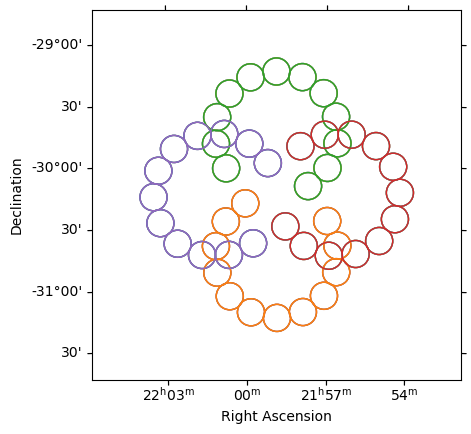

In [17]:
m = Map.create(skydir=source_position, width=(3, 3), proj="TAN")
ax = m.plot(vmin=-1, vmax=0)
plot_spectrum_datasets_off_regions(datasets=datasets, ax=ax)

In [18]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,71,63.66666793823242,12.637666216084321,7.333333492279053,12.230769567235686,12.230769567235686,nan,2376553.25,757184192.0,1327.2796225799502,1361.99999983087,0.05349287278440322,0.005525085571663194,0.047967788290517045,27,16,wstat,179.15057398777142,88,16.0,192.0,0.0833333358168602
stacked,488,471.25,41.27567871198243,16.75,53.00000225157426,53.00000225157426,nan,3549789.5,1404603136.0,2923.3814141554967,3050.9999998308654,0.16692997965883727,0.00572966631001132,0.16120031334882595,27,18,wstat,1772.5626208138883,201,18.0,216.0,0.0833333358168602
stacked,1300,1272.5,71.26959627761578,27.5,125.38462336670005,125.38462336670005,nan,38543.67578125,1937632000.0,4506.825003515018,4738.999999830864,0.2884514040341234,0.0061018566237987645,0.28234954741032464,27,19,wstat,5231.981655791616,330,19.0,228.0,0.0833333358168602
stacked,2185,2146.416748046875,93.95900247905018,38.58333206176758,203.6923228692725,203.6923228692725,nan,163008.84375,2368244480.0,6068.20214156343,6428.999999830866,0.3600737004184653,0.006358280617828406,0.3537154330020169,27,20,wstat,8998.31079122672,463,20.0,240.00001525878906,0.0833333283662796
stacked,3137,3089.083251953125,113.94693138704682,47.91666793823242,285.5384893720669,285.5384893720669,nan,511080.0,2737153792.0,7636.079726788242,8117.99999983087,0.41081289251015085,0.00627503505105313,0.4045378469682902,27,21,wstat,13179.101347314268,575,21.0,252.0,0.0833333358168602
stacked,3911,3854.083251953125,127.70961624233223,56.91667175292969,353.384648722304,353.384648722304,nan,3783955.25,3059316992.0,9198.43884948178,9805.999999830869,0.4251808447060924,0.006187644738882648,0.4189931916729822,27,21,wstat,16509.549803328253,683,21.0,251.99996948242188,0.0833333432674408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,6803,6695.91650390625,167.3992161871018,107.0833511352539,622.1539012327698,622.1539012327698,nan,43559808.0,4278407936.0,15456.583769219953,16560.999999830867,0.44013606768317126,0.006928008978833884,0.43320804932590695,27,22,wstat,28281.09030124182,1285,22.0,263.99993896484375,0.08333335071802139


Before fitting we stack the `Datasets` into a single `SpectrumDatasetOnOff`:

In [19]:
stacked_dataset = datasets.stack_reduce(name='PKS stacked')
print(stacked_dataset)

SpectrumDatasetOnOff
--------------------

  Name                            : PKS stacked 

  Total counts                    : 7724 
  Total background counts         : 151.42
  Total excess counts             : 7572.58

  Predicted counts                : 733.92
  Predicted background counts     : 733.92
  Predicted excess counts         : nan

  Exposure min                    : 4.60e+07 m2 s
  Exposure max                    : 6.86e+09 m2 s

  Number of total bins            : 27 
  Number of fit bins              : 22 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 31071.70

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1817 
  Acceptance                      : 22 
  Acceptance off                  : 264 



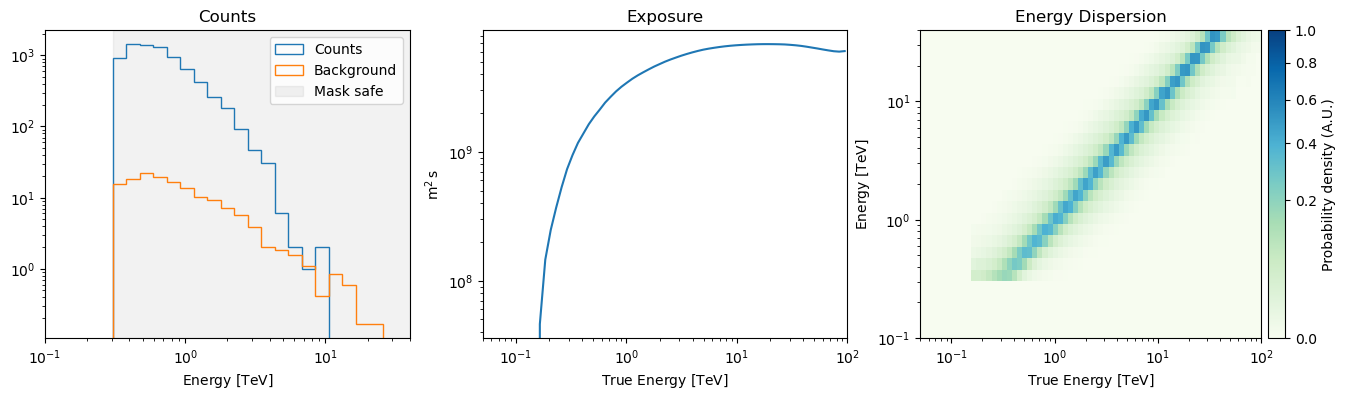

In [20]:
stacked_dataset.peek()

## Data Fitting

In this section we fit a spectral model to the data. In particular, we can use the [likelihood ratio test](https://docs.gammapy.org/1.2/user-guide/stats/index.html#estimating-ts) to compare two different hypotheses:
- H0: Background only (no source)
- H1: Background + source described by a power law model


### **H0**

The value of the quantity $-2\ln\mathcal(L)$ for the background-only model (null hypothesis) can be simply computed as

In [21]:
Wstat_0 = stacked_dataset.stat_sum()
print(Wstat_0)

31071.701525631404


Since the background has been estimated using the reflected regions method, here $-2\ln\mathcal(L)$ corresponds to the so-called [Wstat](https://docs.gammapy.org/1.2/user-guide/references.html#term-WStat) fit statistic.

We can inspect the model residuals for the H0 hypothesis:

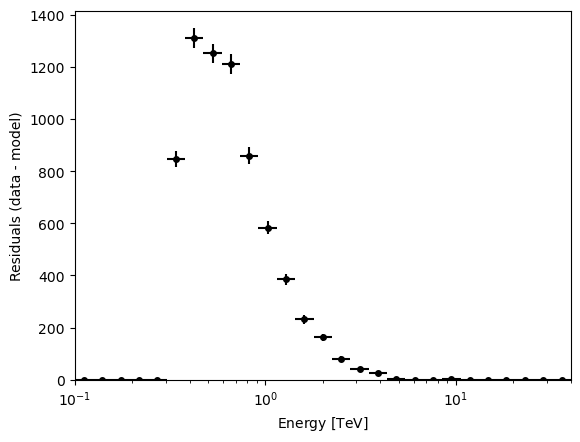

In [22]:
stacked_dataset.plot_residuals_spectral();

As expected, the residuals show a clear positive feature indicating that a source is missing in the model. 

## **H1**
We now add a source defined by a power law spectrum to the model. Here we also consider EBL absorption.

In [23]:
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    EBLAbsorptionNormSpectralModel
)

In [24]:
spectral_model = PowerLawSpectralModel(
    index=3.4, amplitude=2e-11 * u.Unit("1 / (cm2 s TeV)"), reference=1 * u.TeV
)  
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin(redshift=redshift)
spectral_model_1 = spectral_model * ebl

pks_model_1 = SkyModel(spectral_model=spectral_model_1, name="PKS model EBL")

In [25]:
stacked_dataset.models = [pks_model_1]

In [26]:
from gammapy.modeling import Fit

In [27]:
fit1 = Fit()
result1 = fit1.run(datasets=[stacked_dataset])
print(result1)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : 186.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [28]:
result1.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str13,str1,str10,float64,str14,float64,float64,float64,bool,bool,str1,str1
PKS model EBL,,index,2.6623e+00,,2.190e-02,nan,nan,False,False,,
PKS model EBL,,amplitude,2.5907e-10,TeV-1 s-1 cm-2,4.324e-12,nan,nan,False,True,,
PKS model EBL,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
PKS model EBL,,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,,
PKS model EBL,,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,,


In [29]:
Wstat_1 = result1.total_stat
print(f"delta TS of H1 vs H0: {Wstat_0-Wstat_1}")

delta TS of H1 vs H0: 30885.54861235634


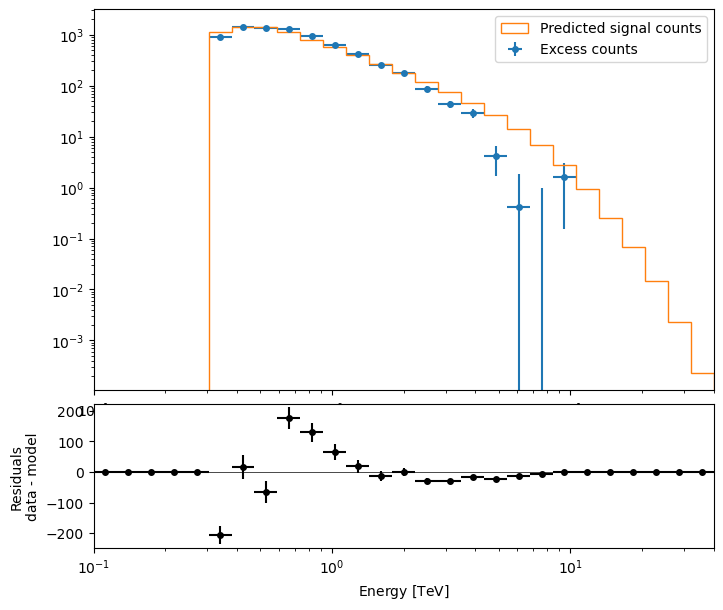

In [30]:
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

Check the convergence of the fit

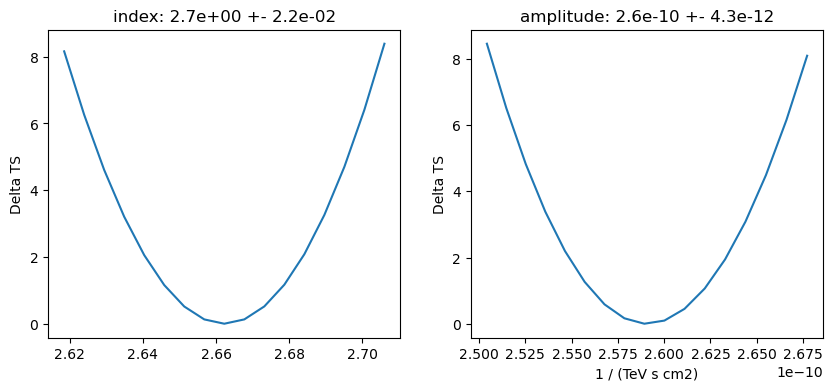

In [31]:
total_stat = result1.total_stat

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for ax, par in zip(axes, pks_model_1.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit1.stat_profile(datasets=[stacked_dataset], parameter=par)
    ax.plot(profile[f"{pks_model_1.name}.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

We can compute flux points for the H1 model assumption.

In [32]:
from gammapy.estimators import FluxPointsEstimator

In [33]:
energy_edges = np.logspace(-0.7, 1.6, 10)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model_1.name, selection_optional=["ul"])

In [34]:
flux_points = fpe.run(datasets=[stacked_dataset])

In [35]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,is_ul,counts,success
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,bool,float64[1],bool
0.27144176165949063,0.19458877175763883,0.37864790094146467,6.725362205778203e-09,1.299160022684073e-09,3.3309243546853715e-10,0.8155648518022687,0.02720808305182771,0.87118535073717,3789.45886255995,61.55858073867485,930.9881108446658,915.2381,1.520438672741875e-07,3789.458862711994,False,931.0,True
0.4727245378085489,0.37864790094146467,0.590174904154169,1.0911543940828165e-09,2.3922937988875624e-10,1.0955783207542172e-10,0.9825189484749105,0.0187985372567058,1.0205834598623817,11749.521625834672,108.39521034545147,2816.1184496332726,2775.2104,2.3899807084198983,11751.911606543092,False,2816.0,True
0.8232649511265537,0.590174904154169,1.14841409721542,1.4957053679627177e-10,9.290640780470001e-11,7.09505053094461e-11,1.148511921147866,0.02162112922102492,1.1923113017175646,11904.04956705355,109.10568072769424,2924.026125595714,2874.3662,0.7001765245404385,11904.74974357809,False,2924.0,True
1.601981156708287,1.14841409721542,2.234684886463062,1.4900074635718673e-11,1.7628363298932288e-11,2.6469704279881427e-11,1.0043133365002779,0.035148339514442725,1.0762196553962902,3138.2441947370535,56.020033869474354,871.1424111921536,844.3221,1.4829036258129236,3139.7270983628664,False,871.0,True
2.789901587924842,2.234684886463062,3.483064174933826,2.4457581201494933e-12,3.148422660081426e-12,8.51937412608917e-12,0.6797087237135542,0.06182548818960585,0.8103634026948342,385.2910943495897,19.628833239639835,140.03553042855754,130.45515,1.6971979628162899,386.988292312406,False,140.0,True
4.858703136246005,3.483064174933826,6.77765179753407,3.1700429682136586e-13,1.171008819971077e-12,5.209384793215627e-12,0.40488933915330677,0.0735736185922359,0.5679069615535524,78.79993533940947,8.87693276641259,39.898065533785925,34.556293,14.013655863255252,92.81359120266472,False,39.0,True
9.454490756170982,6.77765179753407,13.188549386831081,1.050677260052887e-14,9.955312117696797e-14,7.998094006121827e-13,0.12257436729819121,0.17307077726025025,0.5978174994162497,0.6514189959704559,0.8071053190076596,3.5709067854099508,1.2848853,3.639972305072728,4.291391301043184,True,3.0,True
16.465299022531074,13.188549386831081,20.556170656043893,2.757459609203232e-18,2.329247661320841e-16,3.2396629856344293e-15,-2.3064324349784595,0.7688108079648148,3.9560974573932826,1.4288257014368302,-1.1953349745727473,2.220446049250313e-16,-0.74950516,0.011943077951580339,1.4407687793884105,True,0.0,True


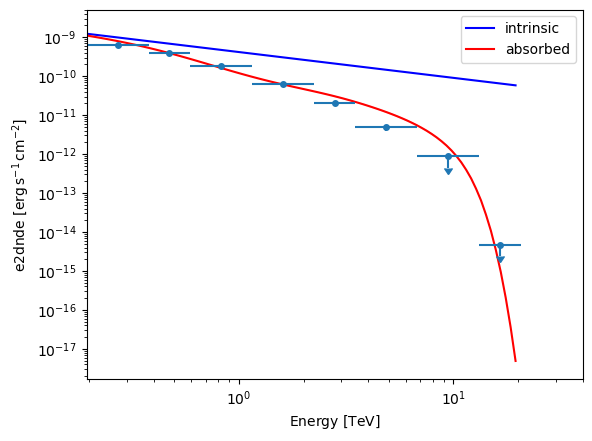

In [36]:
energy_bounds = [0.1, 20] * u.TeV
sed_type = "e2dnde"

ax = spectral_model.plot(energy_bounds=energy_bounds, sed_type=sed_type, label="intrinsic", color="blue")

spectral_model_1.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, label="absorbed", color="red")
spectral_model_1.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, facecolor="red")

flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend();

# Exercises:

- Select and analyze observations of PSK 2155-304 during its steady state 
- Try other models, eg: log-parabola, broken power law, etc. See the model gallery for a list of available models: https://docs.gammapy.org/1.2/user-guide/model-gallery/index.html
- What is the impact of changing the OFF regions criteria (their number, shape, finding method)? 
- Try to repeat the fit using a different minimizer. By default Gammapy uses Minuit, but it also supports the Sherpa and Scipy backends.
- Try another spectral model for the H1 hypthesis: Background + source described by a power law model with exponential cutoff
- Try producing the lightcurve

## Advanced
- Create a gammapy.estimators.FluxPointsDataset with the flux points you have computed for the stacked dataset and fit the flux points again with one of the spectral models. How does the result compare to the best fit model, that was directly fitted to the counts data?
- Compute a 2-dimensional likelihood contour to estimate the correlation between the fitted parameters (e.g. the spectral index and cutoff). (Tutorial reference: https://docs.gammapy.org/1.2/tutorials/api/fitting.html)
- Repeat exercise on the Crab runs available in GAMMAPY_DATA. Alternatively, if you have access to CTA DC1 simulated data, repeat on your favourite source 